# This is where I estimate baseline, naive, and ppi corrected inference parameters for each model classic, bert and gpt_zeroshot

In [1]:
import pandas as pd
import numpy as np
import os
import sys
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

# load custom local packages
# sys.path.append("C:\\Users\\Adam\\Desktop\\code_projects\\GitHub\\va_nlp\\utils")
sys.path.append('/Users/adam/Desktop/Github/va_nlp/utils')

from dataset_utils import dataframe_decorator
from statistics_utils import *
from ppi_plusplus_multi import *

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## load data

In [2]:
df = pd.read_csv('../src/gpt_nlp/results_df.csv')
mexico_knn = pd.read_csv('../data/results/mexico_KNN.csv')
mexico_svm = pd.read_csv('../data/results/mexico_SVM.csv')
mexico_nb = pd.read_csv('../data/results/mexico_NB.csv')
mexico_bert = pd.read_csv('../data/results/mexico_bert.csv')
mexico_gpt4zs = pd.read_csv('../data/results/mexico_gpt4_zs.csv')

up_knn = pd.read_csv('../data/results/up_KNN.csv')
up_svm = pd.read_csv('../data/results/up_SVM.csv')
up_nb = pd.read_csv('../data/results/up_NB.csv')
up_gpt4zs = pd.read_csv('../data/results/up_gpt4_zs.csv')

In [3]:
up_gpt4zs['Y_hat'].value_counts()

Y_hat
4               806
2               297
3               133
1                53
unclassified     51
0                40
Name: count, dtype: int64

In [4]:
def plot_confusion_matrix(site, model):
    '''
    site (str): Site in ['mexico', 'ap', 'up', 'dar', 'bohol', 'pemba']
    model (str): Model in ['KNN', 'SVM', 'NB', 'bert', 'gpt4_zs']
    
    Creates confusion matrix and plots the associated heatmap.    
    '''
    
    load_df = pd.read_csv(f'../data/results/{site}_{model}.csv')
    # drop unclassified and convert to int
    load_df = load_df[load_df['Y_hat'] != 'unclassified'].astype(int)
    
    # Confusion matrix data
    conf_matrix_data = list(confusion_matrix(load_df['Y'], load_df['Y_hat']))

    # Labels for rows and columns
    cod_labels = ['aids-tb', 'communicable', 'external', 'maternal', 'non-communicable']

    # Create a DataFrame from the confusion matrix data and labels
    conf_matrix_df = pd.DataFrame(conf_matrix_data, index=cod_labels, columns=cod_labels)

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_df, annot=True, cmap="Blues", fmt='g', cbar=False, 
                xticklabels=True, yticklabels=True)

    # Rotate y-labels by 90 degrees
    plt.yticks(rotation=0)

    # Move x labels to top
    plt.tick_params(axis='x', labeltop=True, labelbottom=False)

    # Add labels and title
    plt.title(f'Confusion Matrix for Predictions with {model}')

    # Display the plot
    plt.show()

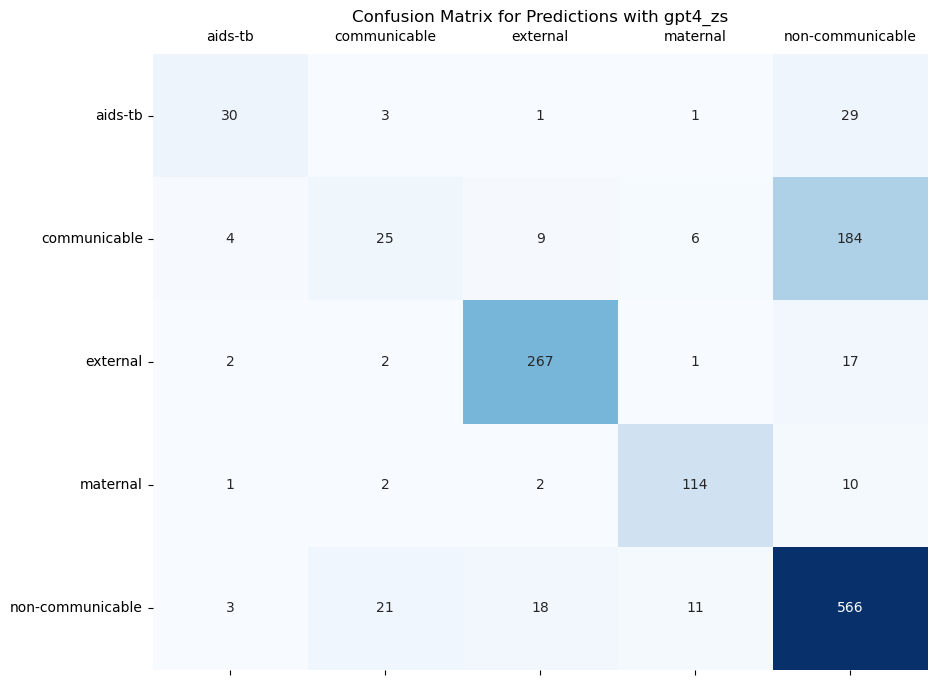

In [5]:
plot_confusion_matrix('up', 'gpt4_zs')

In [6]:
mexico_bert['Y_hat'].value_counts()

Y_hat
4    952
2    323
3     31
Name: count, dtype: int64

In [7]:
mexico_bert['Y'].value_counts()

Y
4    900
1    140
2    121
0    111
3     34
Name: count, dtype: int64

In [8]:
label_to_score = {
    'aids-tb': 0,
    'communicable': 1,
    'external': 2,
    'maternal': 3, 
    'non-communicable': 4, 
    'unclassified': 'unclassified'
}

cod_labels = ['aids-tb', 'communicable', 'external', 'maternal', 'non-communicable']

# Break into 80/20 split for Naive and PPI estimation

In [250]:
def data_split(df, test_size=0.2):
    '''
    Takes input df which has three columns, [Y, X, Y_hat]
    Subsets df to exclude 'unclassified' from Y_hat 
    returns data split unlabeled/labeled with a default 80/20 train/test split:
        Y_sorted (ndarray): All gold-standard labels, sorted. 
        X_sorted (ndarray): All covariates corresponding to the gold-standard labels, sorted. 
        Y_lab (ndarray) : test_size number of gold standard labels.
        Yhat_lab (ndarray): test_size number of predictions corresponding to the gold-standard labels.
        X_lab (ndarray) : test_size number of covariates corresponding to the gold-standard labels.        
        Yhat_unlabeled (ndarray): (1-test_size) number of predictions corresponding to the gold-standard labels.
        X_unlabeled (ndarray): (1-test_size) number of covariates corresponding to the unlabeled data.
             
    '''
    
    # subset to exclude unclassified predictions
    df = df[df['Y_hat']!='unclassified'].astype(int)
    
    # random split by each class
    np.random.seed(123)
    
#     # SPLIT ON 20% OF EACH CLASS
#     # Initialize empty lists to store the splits
#     split_labeled_dfs = []
#     split_unlabeled_dfs = []
#     # Iterate over each unique class
#     for cod_class in df['Y_hat'].unique():
#         # Step 1: Create a subset DataFrame for the current class
#         class_subset = df[df['Y_hat'] == cod_class]
        
#         # Check if there are at least 2 observations for this class
#         if len(class_subset) < 2:
#             # If there is only 1 observation, include it in the 80% split
#             split_labeled_dfs.append(pd.DataFrame())  # Empty DataFrame for 20% split
#             split_unlabeled_dfs.append(class_subset)
#         else:
#             # Step 2: Split the subset into 20% and 80%
#             split_labeled, split_unlabeled = train_test_split(class_subset, test_size=test_size, random_state=42)

#             # Step 3: Append the splits to the respective lists
#             split_labeled_dfs.append(split_labeled)
#             split_unlabeled_dfs.append(split_unlabeled)
#     # Step 4: Merge the 20% splits and 80% splits into separate DataFrames
#     labeled_df = pd.concat(split_labeled_dfs)
#     unlabeled_df = pd.concat(split_unlabeled_dfs)
    
    #JUST SPLIT ON 20% of DATA
    labeled_df = df.sample(frac=test_size)
    unlabeled_df = df.drop(labeled_df.index)
    
    # not split
    Y = df['Y'].to_numpy()
    X = df['X'].to_numpy()
    X = X.reshape(-1,1)
    Yhat = df['Y_hat'].to_numpy()
    sort_idx1 = np.argsort(Y)
    Y_sorted = Y[sort_idx1]
    X_sorted = X[sort_idx1]
    Yhat_sorted = Yhat[sort_idx1]

    # labeled split
    Y_lab = labeled_df['Y'].to_numpy()
    X_lab = labeled_df['X'].to_numpy()
    X_lab = X_lab.reshape(-1,1)
    Yhat_lab = labeled_df['Y_hat'].to_numpy()
    
    # unlabeled split
    Y_unlab = unlabeled_df['Y'].to_numpy()
    X_unlab = unlabeled_df['X'].to_numpy()
    X_unlab = X_unlab.reshape(-1,1)
    Yhat_unlab = unlabeled_df['Y_hat'].to_numpy()
        
    # combine labeled with unlabeled
    Y_full = np.concatenate((Y_lab, Yhat_unlab))
    X_full = np.concatenate((X_lab, X_unlab))
    sort_idx2 = np.argsort(Y_full)
    Y_full_sorted = Y_full[sort_idx2]
    X_full_sorted = X_full[sort_idx2]
    
    return Y_sorted, X_sorted, Yhat_sorted, Y_lab, X_lab, Yhat_lab, Y_unlab, X_unlab, Yhat_unlab, Y_full_sorted, X_full_sorted

In [251]:
Y_sorted, X_sorted, Yhat_sorted, Y_lab, X_lab, Yhat_lab, Y_unlab, X_unlab, Yhat_unlab, Y_full_sorted, X_full_sorted = data_split(mexico_knn)


# Functions to estimate and return baseline, naive and ppi++ inference estimates

In [252]:
def baseline_inference(Ylab, Xlab):
    '''
    Ylab (ndarray): true Y labels
    Xlab (ndarray): true X values
    perform MNLogistic regression Y~X
    returns lists of point estimates and confidence intervals
    '''
    
    mn_logit = sm.MNLogit(Ylab, Xlab)
    mn_logit_res = mn_logit.fit(method = "newton", full_output = True)
    pe = mn_logit_res.params
    ci = mn_logit_res.conf_int()
    
    return pe, ci

In [253]:
pe, ci = baseline_inference(Y_sorted, X_sorted)

Optimization terminated successfully.
         Current function value: 0.961287
         Iterations 7


In [254]:
pe

array([[ 0.01251579,  0.00399583, -0.02938669,  0.04290408]])

In [255]:
ci

array([[[ 0.00745418,  0.0175774 ]],

       [[-0.00158093,  0.00957259]],

       [[-0.03947504, -0.01929834]],

       [[ 0.03854903,  0.04725912]]])

In [256]:
def naive_inference(Ylab, Xlab):
    '''
    Ylab (ndarray): true Y labels
    Xlab (ndarray): true X values
    perform MNLogistic regression on 80/20 unlabeled/labeled split Y_combined ~ X_combined
    returns lists of point estimates and confidence intervals
    '''
    
    mn_logit = sm.MNLogit(Y_full_sorted, X_full_sorted)
    mn_logit_res = mn_logit.fit(method = "newton", full_output = True)
    pe = mn_logit_res.params
    ci = mn_logit_res.conf_int()
   
    return pe, ci

In [257]:
pe, ci = naive_inference(Y_full_sorted, X_full_sorted)

Optimization terminated successfully.
         Current function value: 0.824738
         Iterations 6


In [258]:
pe

array([[ 0.00011151, -0.00022515, -0.0128256 ,  0.04670175]])

In [259]:
ci

array([[[-0.00612879,  0.00635181]],

       [[-0.00649538,  0.00604507]],

       [[-0.02051245, -0.00513874]],

       [[ 0.04210176,  0.05130174]]])

In [260]:
def ppi_inference(X, Y, Yhat, X_unlabeled, Yhat_unlabeled):
    '''
    X (ndarray): Covariates corresponding to the gold-standard labels.
    Y (ndarray): Gold-standard labels.
    Yhat (ndarray): Predictions corresponding to the gold-standard labels.
    X_unlabeled (ndarray): Covariates corresponding to the unlabeled data.
    Yhat_unlabeled (ndarray): Predictions corresponding to the unlabeled data.
    perform ppi++ corrected MNLogit on 80/20 unlabeled/labeled
    returns lists of point estimates and confidence intervals
    '''
    
    theta_ppi_ci = ppi_multiclass_logistic_ci(
                X=X_lab,
                Y=Y_lab,
                Yhat=Yhat_lab,
                X_unlabeled=X_unlab,
                Yhat_unlabeled=Yhat_unlab,
                optimizer_options = {'disp': True, 'maxiter':1000},
            )
    
    pe = theta_ppi_ci['pointest']
    ci = theta_ppi_ci['ci']
    lhat = theta_ppi_ci['lhat']
    se = theta_ppi_ci['se']
   
    return pe, ci, lhat, se

In [261]:
pe, ci, lhat, se = ppi_inference(
    X=X_lab,
    Y=Y_lab,
    Yhat=Yhat_lab,
    X_unlabeled=X_unlab,
    Yhat_unlabeled=Yhat_unlab,
)

In [262]:
pe

array([ 0.01435741, -0.00823518, -0.01918385,  0.04426635])

In [263]:
ci

(array([ 0.00227731, -0.01840376, -0.041147  ,  0.03732461]),
 array([0.02643751, 0.0019334 , 0.0027793 , 0.05120809]))

In [264]:
for i in range(1):
    try:
        # PPI++ correction using the same 80/20 split unlabeled/labeled
        theta_ppi_ci = ppi_multiclass_logistic_ci(
            X=X_lab,
            Y=Y_lab,
            Yhat=Yhat_lab,
            X_unlabeled=X_unlab,
            Yhat_unlabeled=Yhat_unlab,
            optimizer_options = {'disp': True, 'maxiter':1000},
        )
        print(theta_ppi_ci)
    except Exception as e:
        # Handle the exception (if needed)
        print("Error:", e)
        # Continue with the loop
        continue

{'pointest': array([ 0.01435741, -0.00823518, -0.01918385,  0.04426635]), 'ci': (array([ 0.00227731, -0.01840376, -0.041147  ,  0.03732461]), array([0.02643751, 0.0019334 , 0.0027793 , 0.05120809])), 'se': array([0.00734418, 0.00618206, 0.01335265, 0.00422028]), 'lhat': 0.1347418626418477}


# Site: geographic regions (mexico, ap, up, dar, bohol, pemba)
# Model: ai prediction model (classic, BERT, GPT4)
# Inference: type of inference (Baseline, Naive, PPI++)

# Loop through all permutations, compute PE and CI, save results 

In [265]:
sites = df['site'].unique()
models = ['KNN', 'SVM', 'NB', 'bert', 'gpt4_zs']
results_list = []
column_names=  [
    'site', 'model',
    'baseline_pe', 'baseline_ci',
    'naive_pe', 'naive_ci',
    'ppi_pe', 'ppi_ci', 'ppi_lhat', 'ppi_se'
]

np.random.seed(42)
for site in tqdm(sites):
    for model in tqdm(models):
        # read in dataframe for site and model
        load_df = pd.read_csv(f'../data/results/{site}_{model}.csv')

        # split data 
        Y_sorted, X_sorted, Yhat_sorted, Y_lab, X_lab, Yhat_lab, Y_unlab, X_unlab, Yhat_unlab, Y_full_sorted, X_full_sorted = data_split(load_df)

        try:
            # baseline predictions
            baseline_pe, baseline_ci = baseline_inference(Y_sorted, X_sorted)

            # naive predictions
            naive_pe, naive_ci = naive_inference(Y_full_sorted, X_full_sorted)

            # ppi++ predictions
            ppi_pe, ppi_ci, ppi_lhat, ppi_se = ppi_inference(
                X=X_lab,
                Y=Y_lab,
                Yhat=Yhat_lab,
                X_unlabeled=X_unlab,
                Yhat_unlabeled=Yhat_unlab,
            )

        except Exception as e:
            # Handle the exception (if needed)
            print("Error:", e)
            # Continue with the loop
            continue

        result = [
            site, model,
            baseline_pe, baseline_ci,
            naive_pe, naive_ci,
            ppi_pe, ppi_ci, ppi_lhat, ppi_se
        ]

        results_list.append(result)

# Create DataFrame
results_df = pd.DataFrame(results_list, columns=column_names)

# write to results folder
results_df.to_csv('../data/results/estimation_results.csv', index=False)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: 0.961287
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.824738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.961287
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.699056
         Iterations 7
Error: Singular matrix
Optimization terminated successfully.
         Current function value: 0.961287
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.365831
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.961287
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.818104
         Iterations 7
Optimization terminated successfully.
         Current function value: 1.068674
         Iterations 7
Optimization terminated successfully.
         Current func

  0%|          | 0/5 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: 1.228118
         Iterations 6
Optimization terminated successfully.
         Current function value: 1.030722
         Iterations 7
Optimization terminated successfully.
         Current function value: 1.228118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.922293
         Iterations 7
Optimization terminated successfully.
         Current function value: 1.228118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.560564
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.502735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.502735
         Iterations 5
Error: index 4 is out of bounds for axis 0 with size 2
Optimization terminated successfully.
         Current function value: 1.224239
         Iterations 6
Optimization terminated suc

  0%|          | 0/5 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: 1.283214
         Iterations 6
Optimization terminated successfully.
         Current function value: 1.048470
         Iterations 7
Optimization terminated successfully.
         Current function value: 1.283214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.942132
         Iterations 7
Optimization terminated successfully.
         Current function value: 1.283214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.627660
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690714
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690714
         Iterations 3
Error: index 4 is out of bounds for axis 0 with size 2
Optimization terminated successfully.
         Current function value: 1.281369
         Iterations 6
Optimization terminated suc

  0%|          | 0/5 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: 1.180551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.595348
         Iterations 6
Optimization terminated successfully.
         Current function value: 1.180551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.610401
         Iterations 7
Optimization terminated successfully.
         Current function value: 1.180551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451214
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.160539
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.160539
         Iterations 9
Error: index 4 is out of bounds for axis 0 with size 3
Optimization terminated successfully.
         Current function value: 1.222207
         Iterations 6
Optimization terminated suc

  0%|          | 0/5 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: 1.010036
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.807817
         Iterations 7
Optimization terminated successfully.
         Current function value: 1.010036
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689003
         Iterations 7
Optimization terminated successfully.
         Current function value: 1.010036
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.369672
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.390735
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.390735
         Iterations 10
Error: index 4 is out of bounds for axis 0 with size 3
Optimization terminated successfully.
         Current function value: 1.013905
         Iterations 7
Optimization terminated s

  0%|          | 0/5 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: 1.435306
         Iterations 7
Optimization terminated successfully.
         Current function value: 1.390964
         Iterations 7
Error: index 4 is out of bounds for axis 0 with size 4
Optimization terminated successfully.
         Current function value: 1.435306
         Iterations 7
Optimization terminated successfully.
         Current function value: 1.157168
         Iterations 7
Error: index 4 is out of bounds for axis 0 with size 4
Optimization terminated successfully.
         Current function value: 1.435306
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.786157
         Iterations 6
Error: index 4 is out of bounds for axis 0 with size 4
Optimization terminated successfully.
         Current function value: 1.435306
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.854723
         Iterations 7
Error: index 4 is o

In [266]:
results_df.shape

(21, 10)

In [267]:
results_df.head()

,site,model,baseline_pe,baseline_ci,naive_pe,naive_ci,ppi_pe,ppi_ci,ppi_lhat,ppi_se
0,mexico,KNN,"[[0.0125157900649883, 0.003995833892191664, -0...","[[[0.007454184279145533, 0.017577395850831068]...","[[0.0001115077176901842, -0.000225154950157286...","[[[-0.006128794574323466, 0.006351810009703835...","[0.01435740973474081, -0.00823518438209308, -0...","([0.0022773081643706963, -0.018403764031196368...",0.134742,"[0.007344180279894602, 0.006182057468511323, 0..."
1,mexico,NB,"[[0.0125157900649883, 0.003995833892191664, -0...","[[[0.007454184279145533, 0.017577395850831068]...","[[0.021018400428029504, 0.014924948516510184, ...","[[[0.007387433606168704, 0.0346493672498903]],...","[0.015525029184210313, -0.0072878845290533035,...","([0.0036265174888217237, -0.017817241655873253...",0.648715,"[0.00723378147479358, 0.0064013946008890646, 0..."
2,mexico,bert,"[[0.0125157900649883, 0.003995833892191664, -0...","[[[0.007454184279145533, 0.017577395850831068]...","[[0.019727828448456757, 0.06115924897769239, 0...","[[[0.006522058077401534, 0.03293359881951198]]...","[0.015139814683748505, -0.003469571567069452, ...","([0.002780875035922007, -0.012753752116755935,...",0.016621,"[0.007513701794081354, 0.005644380993884262, 0..."
3,mexico,gpt4_zs,"[[0.01105558293769277, 0.007075625152646656, -...","[[[0.0032466748246653167, 0.018864491050720224...","[[0.002810334077492051, 0.014345259295838719, ...","[[[-0.007138905030868612, 0.012759573185852713...","[0.006299391607955635, 0.006923286927183785, -...","([-0.010039720001167589, -0.001538414805264223...",0.739241,"[0.009933474530135364, 0.00514434937784142, 0...."
4,ap,KNN,"[[-0.004020411834614718, 0.004460880506152113,...","[[[-0.009293965661295193, 0.001253141992065757...","[[0.02350232255985961, 0.028486628206149892, -...","[[[0.015335092614406486, 0.03166955250531273]]...","[0.007346151133878509, 0.00486870290801795, -0...","([-0.0036295418872991283, -0.00135403072531083...",0.606691,"[0.006672747557191271, 0.00378315342554938, 0...."


In [268]:
results_df['site'].value_counts()

site
mexico    4
ap        4
up        4
dar       4
bohol     4
pemba     1
Name: count, dtype: int64

In [269]:
results_df['model'].value_counts()

model
gpt4_zs    6
KNN        5
NB         5
SVM        4
bert       1
Name: count, dtype: int64

# For each site/model/inference permutation, plot to compare the PE + CI 

In [270]:
row = 0

In [271]:
results_df.iloc[row]['ppi_lhat']

0.1347418626418477

In [272]:
import matplotlib.pyplot as plt
import numpy as np

def plot_with_errorbars(site_name, model_name,
                        baseline_pe, naive_pe, ppi_pe, 
                        baseline_ci, naive_ci, ppi_ci,
                        lhat):
    '''
    site_name (str): Name of the site for inference from ['mexico', 'ap', 'up', 'dar', 'bohol', 'pemba']
    model_name (str): Name of the model used from ['KNN', 'NB', 'bert', 'gpt4_zs', 'SVM'].
    baseline_pe (ndarray shape (1,4)): Point estimates from baseline inference. 
    naive_pe (ndarray shape (1,4)): Point estimates from naive inference. 
    ppi_pe (ndarray shape (4,)): Point estimates from ppi++ inference. 
    baseline_ci (ndarray shape (4, 1, 2)): 95% confidence interval estimates from baseline inference. 
    naive_ci (ndarray shape (4, 1, 2)): 95% confidence interval estimates from naive inference. 
    ppi_ci (tuple of ndarrays shape (4,)): 95% confidence interval estimates from ppi++ inference. 
    lhat ()

    This function makes a dot plot with 95% CI error bars to compare the baseline, naive
    and ppi++ inference parameters for the given site and model.
    '''
    
    # Define labels for x-axis (models)
    labels = ['Communicable', 'External', 'Maternal', 'Non-communicable']

    # Define positions for each model
    x = np.arange(len(labels))

    # Define width of each bar
    width = 0.2

    # Create the plot
    fig, ax = plt.subplots()

    # Plot point estimates using specified hexcodes
    ax.scatter(x - width, baseline_pe.flatten(), c='#fde725', label='Ground Truth')
    ax.scatter(x, naive_pe.flatten(), c='#21918c', label='Naïve')
    ax.scatter(x + width, ppi_pe, c='#440154', label='multiPPI++ Correction')

    # Set colors for error bars
    baseline_color = '#fde725'
    naive_color = '#21918c'
    ppi_color = '#440154'

    # Plot error bars
    ax.errorbar(x - width, baseline_pe.flatten(), yerr=np.abs(baseline_ci[:,:,0].flatten() - baseline_pe.flatten()), fmt='none', color=baseline_color)
    ax.errorbar(x, naive_pe.flatten(), yerr=np.abs(naive_ci[:,:,0].flatten() - naive_pe.flatten()), fmt='none', color=naive_color)
    ax.errorbar(x + width, ppi_pe, yerr=np.abs(ppi_ci[0] - ppi_pe), fmt='none', color=ppi_color)

    # Set y-axis limits ( FOR UP SPECIFICALLY )
#     ax.set_ylim(-0.04, 0.16)

    # Add labels, title, and legend
    ax.set_ylabel('Log Odds Ratio')
    ax.set_xlabel('Cause of Death Label')
    #ax.set_title(f'{site_name} {model_name}')
    ax.set_title(f'{site_name} {model_name}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc='upper left')


    return fig


  0%|          | 0/21 [00:00<?, ?it/s]

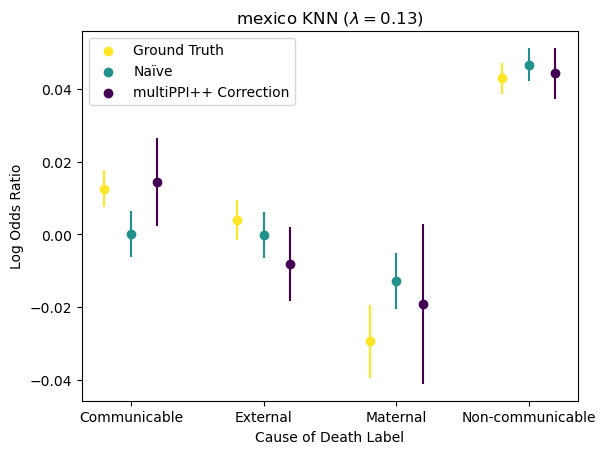

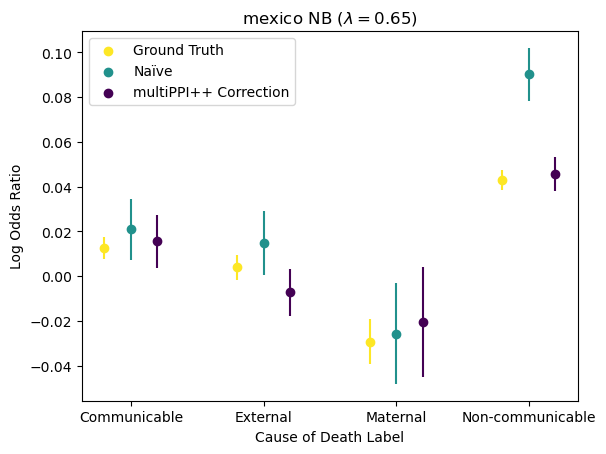

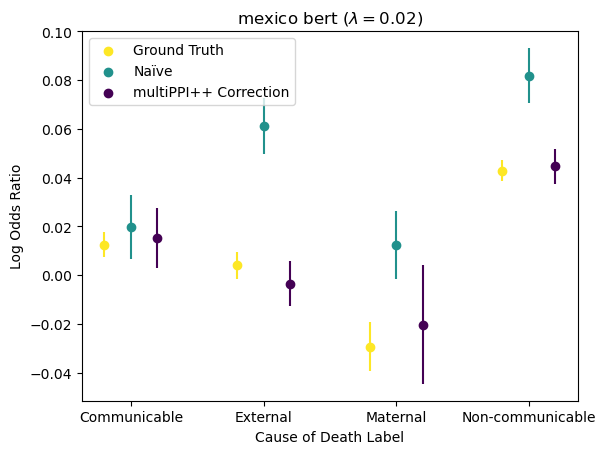

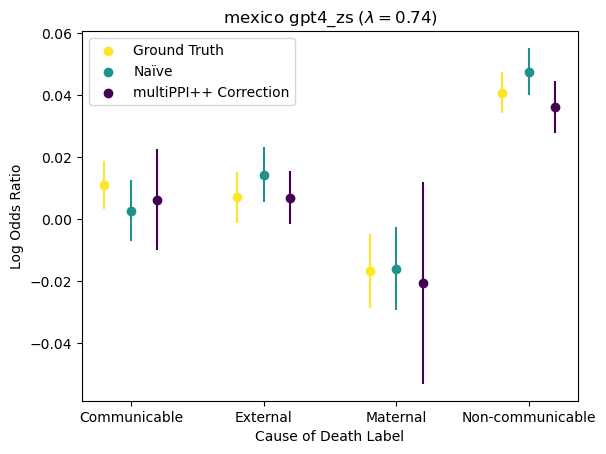

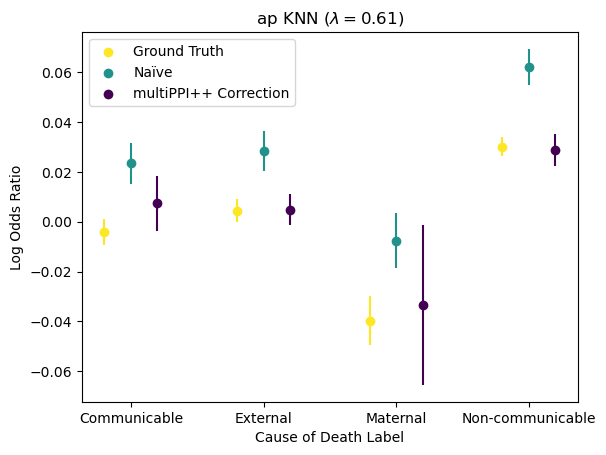

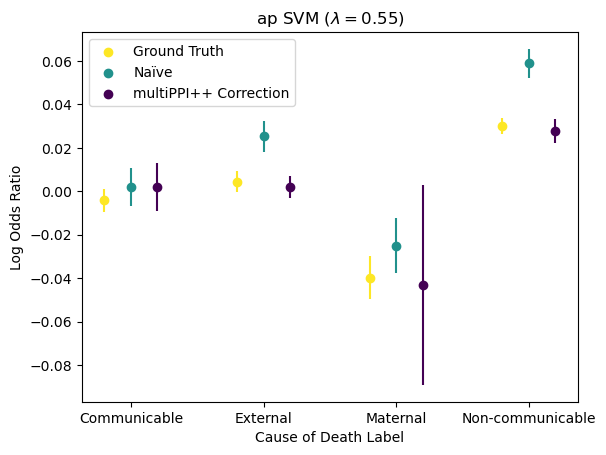

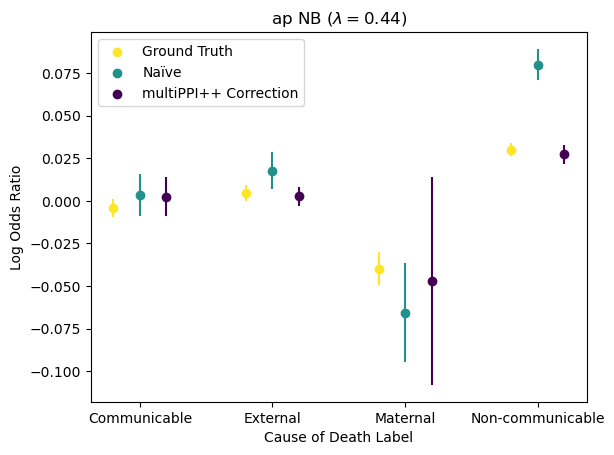

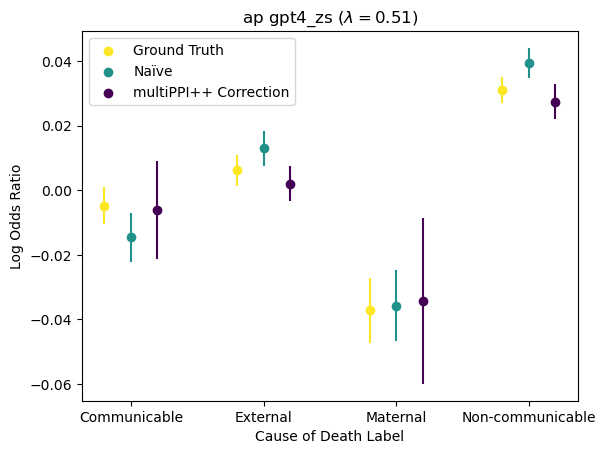

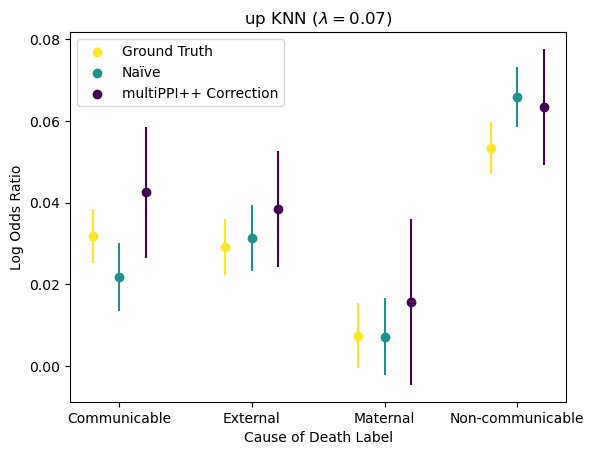

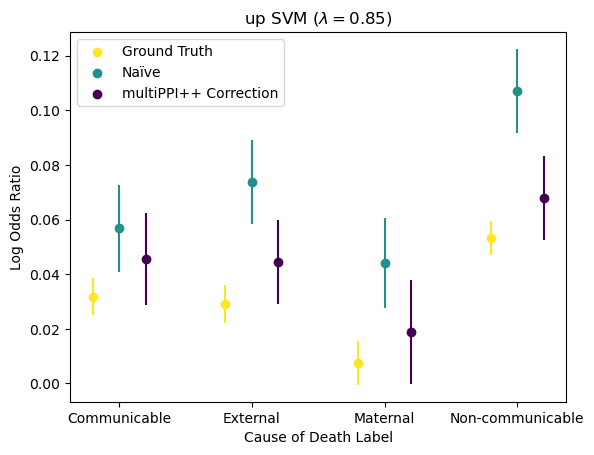

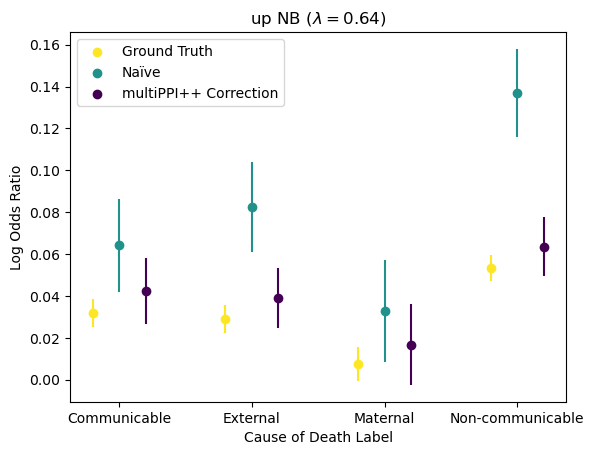

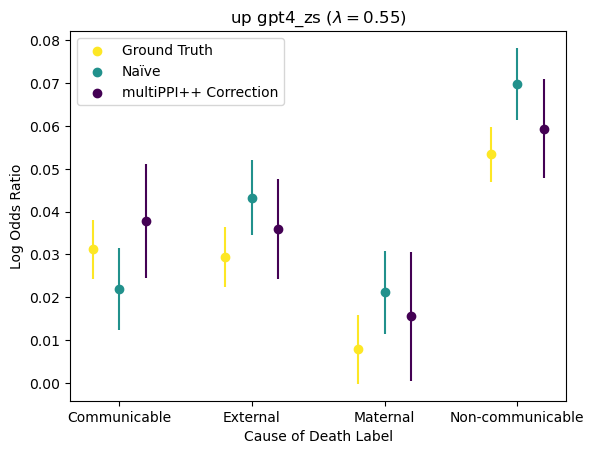

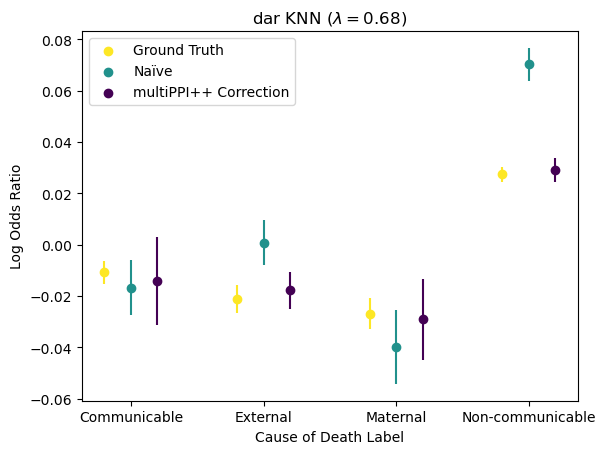

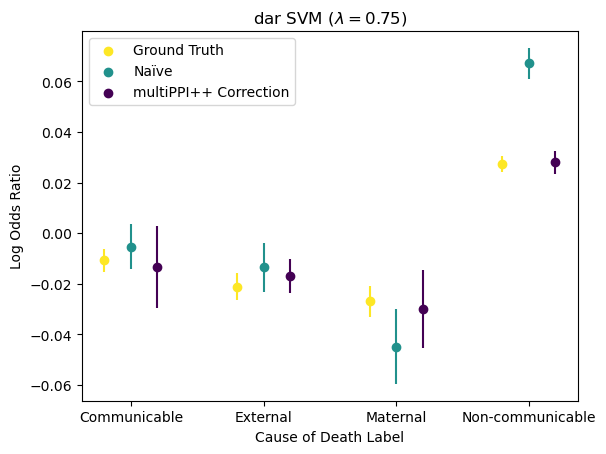

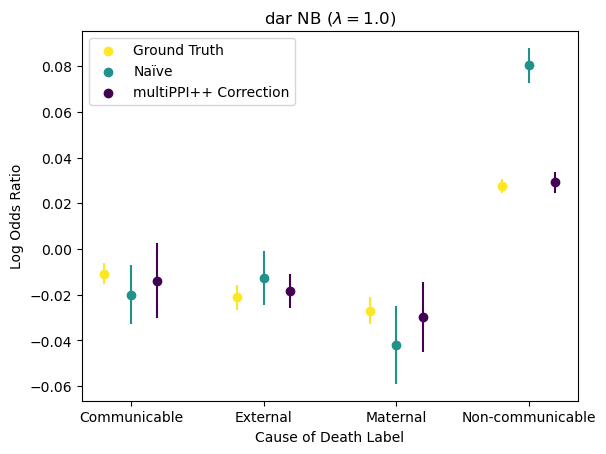

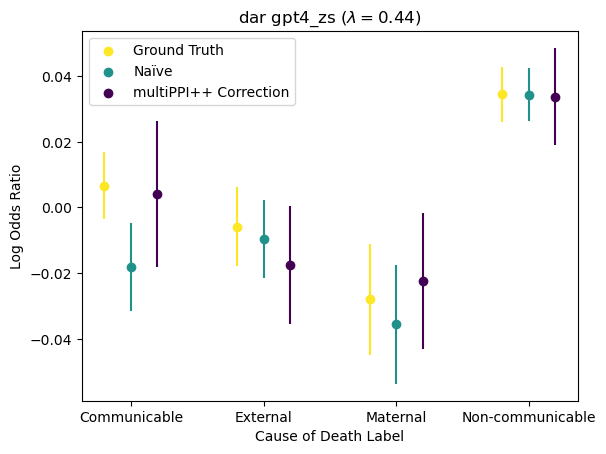

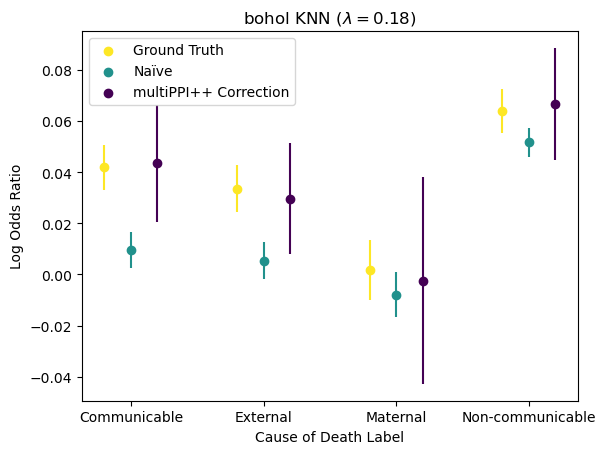

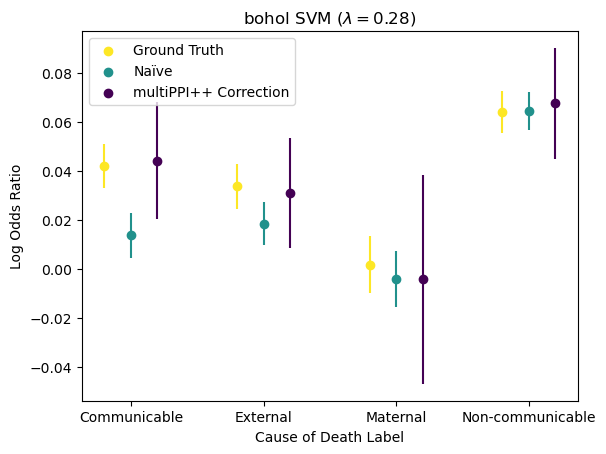

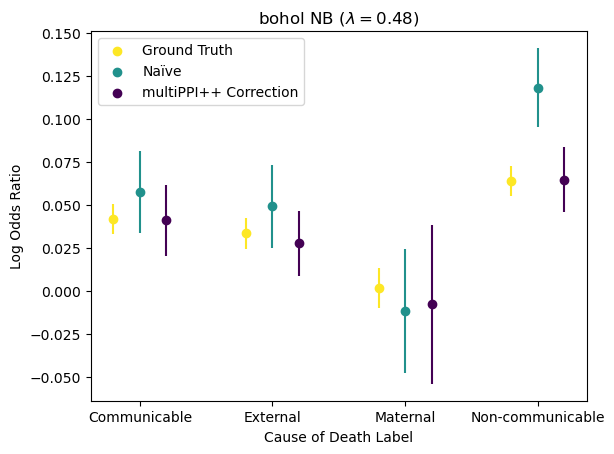

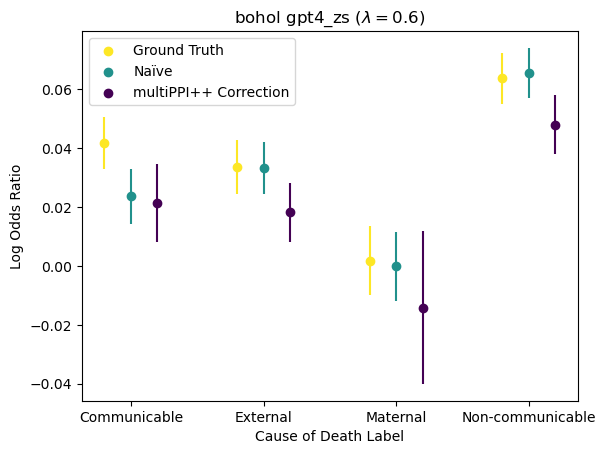

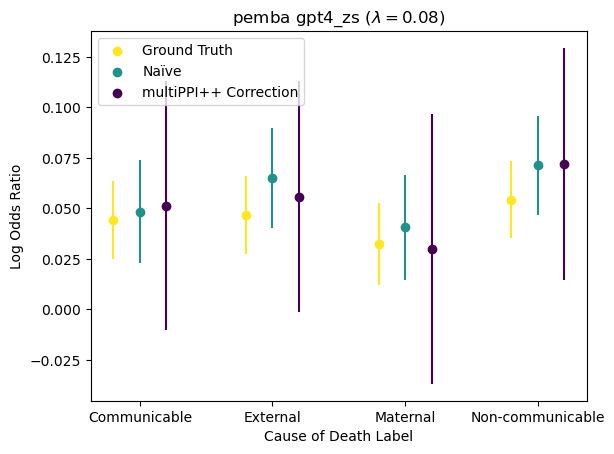

In [273]:
# Create PDF to save plots
pdf_pages = PdfPages('../data/results/inference_results.pdf')

# loop through rows of results_df
for row in tqdm(range(results_df.shape[0])):
    site_name = results_df.iloc[row]['site']
    model_name = results_df.iloc[row]['model']
    baseline_pe = results_df.iloc[row]['baseline_pe']
    naive_pe = results_df.iloc[row]['naive_pe']
    ppi_pe = results_df.iloc[row]['ppi_pe']
    baseline_ci = results_df.iloc[row]['baseline_ci']
    naive_ci = results_df.iloc[row]['naive_ci']
    ppi_ci = results_df.iloc[row]['ppi_ci']
    lhat = results_df.iloc[row]['ppi_lhat']
    
    # make plot
    fig = plot_with_errorbars(site_name, model_name,
                          baseline_pe, naive_pe, ppi_pe, 
                          baseline_ci, naive_ci, ppi_ci,
                          lhat)

    # save to pdf
    pdf_pages.savefig(fig)

# Close the PDF
pdf_pages.close()

In [274]:
mexico_knn['Y_hat'].value_counts()

Y_hat
4    1045
2      94
0      72
1      52
3      43
Name: count, dtype: int64

In [275]:
mexico_nb['Y_hat'].value_counts()

Y_hat
4    1281
2      24
3       1
Name: count, dtype: int64

In [276]:
mexico_bert['Y_hat'].value_counts()

Y_hat
4    952
2    323
3     31
Name: count, dtype: int64

In [277]:
mexico_gpt4zs['Y_hat'].value_counts()

Y_hat
4    388
2     65
0     31
1     25
3     21
Name: count, dtype: int64

In [278]:
up_gpt4zs = up_gpt4zs[up_gpt4zs['Y_hat']!='unclassified'].astype(int)

In [279]:
# knn
accuracy_score(up_knn['Y_hat'], up_knn['Y'])

0.5927536231884057

In [280]:
# knn
f1_score(up_knn['Y_hat'], up_knn['Y'], average='weighted')

0.6344040251450299

In [281]:
# nb
accuracy_score(up_nb['Y_hat'], up_knn['Y'])

0.5347826086956522

In [282]:
# nb
f1_score(up_nb['Y_hat'], up_nb['Y'], average='weighted')

0.649860962865745

In [283]:
# svm
accuracy_score(up_svm['Y_hat'], up_svm['Y'])

0.6572463768115943

In [284]:
# svm
f1_score(up_svm['Y_hat'], up_svm['Y'], average='weighted')

0.7086834940693977

In [285]:
# gpt4
accuracy_score(up_gpt4zs['Y_hat'], up_gpt4zs['Y'])

0.7539503386004515

In [286]:
# gpt4
f1_score(up_gpt4zs['Y_hat'], up_gpt4zs['Y'], average='weighted')

0.796966234001681

In [287]:
mexico_gpt4zs = mexico_gpt4zs[mexico_gpt4zs['Y_hat']!='unclassified'].astype(int)

In [288]:
# bert
accuracy_score(mexico_bert['Y_hat'], mexico_bert['Y'])

0.5773353751914242

In [289]:
# bert
f1_score(mexico_bert['Y_hat'], mexico_bert['Y'], average='weighted')

0.6102297534567271

In [290]:
# gpt4
f1_score(mexico_gpt4zs['Y_hat'], mexico_gpt4zs['Y'], average='weighted')

0.8299252044960188

In [291]:
# gpt4
accuracy_score(mexico_gpt4zs['Y_hat'], mexico_gpt4zs['Y'])

0.8113207547169812

In [292]:
# knn
accuracy_score(mexico_knn['Y_hat'], mexico_knn['Y'])

0.6248085758039816

In [293]:
# knn
f1_score(mexico_knn['Y_hat'], mexico_knn['Y'], average='weighted')

0.6624143314199002

In [294]:
# nb
accuracy_score(mexico_nb['Y_hat'], mexico_nb['Y'])

0.6929555895865237

In [295]:
# nb
f1_score(mexico_nb['Y_hat'], mexico_nb['Y'], average='weighted')

0.8041088656762041

In [296]:
results_df.head()

,site,model,baseline_pe,baseline_ci,naive_pe,naive_ci,ppi_pe,ppi_ci,ppi_lhat,ppi_se
0,mexico,KNN,"[[0.0125157900649883, 0.003995833892191664, -0...","[[[0.007454184279145533, 0.017577395850831068]...","[[0.0001115077176901842, -0.000225154950157286...","[[[-0.006128794574323466, 0.006351810009703835...","[0.01435740973474081, -0.00823518438209308, -0...","([0.0022773081643706963, -0.018403764031196368...",0.134742,"[0.007344180279894602, 0.006182057468511323, 0..."
1,mexico,NB,"[[0.0125157900649883, 0.003995833892191664, -0...","[[[0.007454184279145533, 0.017577395850831068]...","[[0.021018400428029504, 0.014924948516510184, ...","[[[0.007387433606168704, 0.0346493672498903]],...","[0.015525029184210313, -0.0072878845290533035,...","([0.0036265174888217237, -0.017817241655873253...",0.648715,"[0.00723378147479358, 0.0064013946008890646, 0..."
2,mexico,bert,"[[0.0125157900649883, 0.003995833892191664, -0...","[[[0.007454184279145533, 0.017577395850831068]...","[[0.019727828448456757, 0.06115924897769239, 0...","[[[0.006522058077401534, 0.03293359881951198]]...","[0.015139814683748505, -0.003469571567069452, ...","([0.002780875035922007, -0.012753752116755935,...",0.016621,"[0.007513701794081354, 0.005644380993884262, 0..."
3,mexico,gpt4_zs,"[[0.01105558293769277, 0.007075625152646656, -...","[[[0.0032466748246653167, 0.018864491050720224...","[[0.002810334077492051, 0.014345259295838719, ...","[[[-0.007138905030868612, 0.012759573185852713...","[0.006299391607955635, 0.006923286927183785, -...","([-0.010039720001167589, -0.001538414805264223...",0.739241,"[0.009933474530135364, 0.00514434937784142, 0...."
4,ap,KNN,"[[-0.004020411834614718, 0.004460880506152113,...","[[[-0.009293965661295193, 0.001253141992065757...","[[0.02350232255985961, 0.028486628206149892, -...","[[[0.015335092614406486, 0.03166955250531273]]...","[0.007346151133878509, 0.00486870290801795, -0...","([-0.0036295418872991283, -0.00135403072531083...",0.606691,"[0.006672747557191271, 0.00378315342554938, 0...."


# Table to Compare F1 accuracy to PE residuals and ratio of CI width

In [298]:
up_svm = pd.read_csv('../data/results/up_SVM.csv')
up_nb = pd.read_csv('../data/results/up_NB.csv')
up_gpt4zs = pd.read_csv('../data/results/up_gpt4_zs.csv')

In [299]:
# compute residuals
results_df['naive_residual'] = np.abs(results_df['baseline_pe'] - results_df['naive_pe'])
results_df['naive_residual'] = [np.sum(x) for x in results_df['naive_residual']]
results_df['ppi_residual'] = np.abs(results_df['baseline_pe'] - results_df['ppi_pe'])
results_df['ppi_residual'] = [np.sum(x) for x in results_df['ppi_residual']]

In [300]:
# compute ratio of CI widths


results_df['baseline_ci'][0]



array([[[ 0.00745418,  0.0175774 ]],

       [[-0.00158093,  0.00957259]],

       [[-0.03947504, -0.01929834]],

       [[ 0.03854903,  0.04725912]]])

In [301]:
results_df['naive_ci'][0]


array([[[-0.00612879,  0.00635181]],

       [[-0.00649538,  0.00604507]],

       [[-0.02051245, -0.00513874]],

       [[ 0.04210176,  0.05130174]]])

In [302]:
# Assuming intervals_1 and intervals_2 are your arrays
intervals_1 = np.array([[[ 0.00745418,  0.0175774 ]],
                        [[-0.00158093,  0.00957259]],
                        [[-0.03947504, -0.01929834]],
                        [[ 0.03854903,  0.04725912]]])

intervals_2 = np.array([[[-0.00612879,  0.00635181]],
                        [[-0.00649538,  0.00604507]],
                        [[-0.02051245, -0.00513874]],
                        [[ 0.04210176,  0.05130174]]])

# Calculate width of each confidence interval
widths_1 = intervals_1[:, :, 1] - intervals_1[:, :, 0]
widths_2 = intervals_2[:, :, 1] - intervals_2[:, :, 0]

# Calculate ratios for each pair of confidence intervals
ratios = widths_1 / widths_2

print("Widths of intervals 1:", widths_1)
print("Widths of intervals 2:", widths_2)
print("Ratios:", ratios)

Widths of intervals 1: [[0.01012322]
 [0.01115352]
 [0.0201767 ]
 [0.00871009]]
Widths of intervals 2: [[0.0124806 ]
 [0.01254045]
 [0.01537371]
 [0.00919998]]
Ratios: [[0.81111645]
 [0.88940349]
 [1.31241581]
 [0.94675097]]


In [303]:
def prediction_accuracy(site_name, model_name):
    '''
    site_name (str): Name of the site for inference from ['mexico', 'ap', 'up', 'dar', 'bohol', 'pemba']
    model_name (str): Name of the model used from ['KNN', 'NB', 'bert', 'gpt4_zs', 'SVM'].    
    '''
    
    # read in dataframe for site and model
    load_df = pd.read_csv(f'../data/results/{site}_{model}.csv')
    
    


In [304]:
def prediction_f1(site_name, model_name):
    '''
    site_name (str): Name of the site for inference from ['mexico', 'ap', 'up', 'dar', 'bohol', 'pemba']
    model_name (str): Name of the model used from ['KNN', 'NB', 'bert', 'gpt4_zs', 'SVM'].
    
    returns f1 score for predictions made in site_name using model_name
    '''

In [305]:
# loop over rows and get accuracy and f1 scores
accuracy_scores = []
f1_scores = []

for row in tqdm(range(results_df.shape[0])):
    site = results_df.iloc[row][0]
    model = results_df.iloc[row][1]
    
    # read in dataframe for site and model
    load_df = pd.read_csv(f'../data/results/{site}_{model}.csv')
    
    # drop unclassified and convert to int
    load_df = load_df[load_df['Y_hat'] != 'unclassified'].astype(int)    
    
    accuracy = accuracy_score(load_df['Y'], load_df['Y_hat'])
    f1 = f1_score(load_df['Y'], load_df['Y_hat'], average = 'weighted')
    
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    
    
# add to results_df
results_df['accuracy'] = accuracy_scores
results_df['f1'] = f1_scores

  0%|          | 0/21 [00:00<?, ?it/s]

In [306]:
results_df.head()

,site,model,baseline_pe,baseline_ci,naive_pe,naive_ci,ppi_pe,ppi_ci,ppi_lhat,ppi_se,naive_residual,ppi_residual,accuracy,f1
0,mexico,KNN,"[[0.0125157900649883, 0.003995833892191664, -0...","[[[0.007454184279145533, 0.017577395850831068]...","[[0.0001115077176901842, -0.000225154950157286...","[[[-0.006128794574323466, 0.006351810009703835...","[0.01435740973474081, -0.00823518438209308, -0...","([0.0022773081643706963, -0.018403764031196368...",0.134742,"[0.007344180279894602, 0.006182057468511323, 0...",0.036984,0.025638,0.624809,0.587203
1,mexico,NB,"[[0.0125157900649883, 0.003995833892191664, -0...","[[[0.007454184279145533, 0.017577395850831068]...","[[0.021018400428029504, 0.014924948516510184, ...","[[[0.007387433606168704, 0.0346493672498903]],...","[0.015525029184210313, -0.0072878845290533035,...","([0.0036265174888217237, -0.017817241655873253...",0.648715,"[0.00723378147479358, 0.0064013946008890646, 0...",0.070504,0.025959,0.692956,0.581802
2,mexico,bert,"[[0.0125157900649883, 0.003995833892191664, -0...","[[[0.007454184279145533, 0.017577395850831068]...","[[0.019727828448456757, 0.06115924897769239, 0...","[[[0.006522058077401534, 0.03293359881951198]]...","[0.015139814683748505, -0.003469571567069452, ...","([0.002780875035922007, -0.012753752116755935,...",0.016621,"[0.007513701794081354, 0.005644380993884262, 0...",0.144955,0.021026,0.577335,0.544441
3,mexico,gpt4_zs,"[[0.01105558293769277, 0.007075625152646656, -...","[[[0.0032466748246653167, 0.018864491050720224...","[[0.002810334077492051, 0.014345259295838719, ...","[[[-0.007138905030868612, 0.012759573185852713...","[0.006299391607955635, 0.006923286927183785, -...","([-0.010039720001167589, -0.001538414805264223...",0.739241,"[0.009933474530135364, 0.00514434937784142, 0....",0.023031,0.013350,0.811321,0.792716
4,ap,KNN,"[[-0.004020411834614718, 0.004460880506152113,...","[[[-0.009293965661295193, 0.001253141992065757...","[[0.02350232255985961, 0.028486628206149892, -...","[[[0.015335092614406486, 0.03166955250531273]]...","[0.007346151133878509, 0.00486870290801795, -0...","([-0.0036295418872991283, -0.00135403072531083...",0.606691,"[0.006672747557191271, 0.00378315342554938, 0....",0.115668,0.019459,0.624126,0.578642


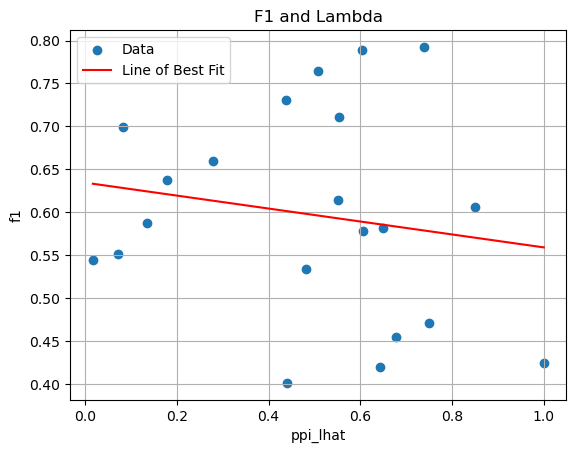

In [307]:
# Extracting data from the DataFrame
x_values = results_df['ppi_lhat']
y_values = results_df['f1']

# Plotting the scatter plot
plt.scatter(x_values, y_values, label='Data')

# Fitting a line of best fit
coefficients = np.polyfit(x_values, y_values, 1)
polynomial = np.poly1d(coefficients)
x_line = np.linspace(min(x_values), max(x_values), 100)
y_line = polynomial(x_line)

# Plotting the line of best fit
plt.plot(x_line, y_line, color='red', label='Line of Best Fit')

# Adding labels and legend
plt.xlabel('ppi_lhat')
plt.ylabel('f1')
plt.title('F1 and Lambda')
plt.legend()

# Displaying the plot
plt.grid(True)
plt.show()

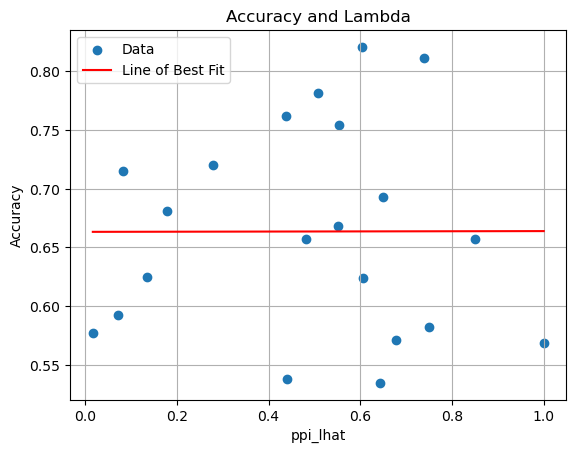

In [308]:
# Extracting data from the DataFrame
x_values = results_df['ppi_lhat']
y_values = results_df['accuracy']

# Plotting the scatter plot
plt.scatter(x_values, y_values, label='Data')

# Fitting a line of best fit
coefficients = np.polyfit(x_values, y_values, 1)
polynomial = np.poly1d(coefficients)
x_line = np.linspace(min(x_values), max(x_values), 100)
y_line = polynomial(x_line)

# Plotting the line of best fit
plt.plot(x_line, y_line, color='red', label='Line of Best Fit')

# Adding labels and legend
plt.xlabel('ppi_lhat')
plt.ylabel('Accuracy')
plt.title('Accuracy and Lambda')
plt.legend()

# Displaying the plot
plt.grid(True)
plt.show()

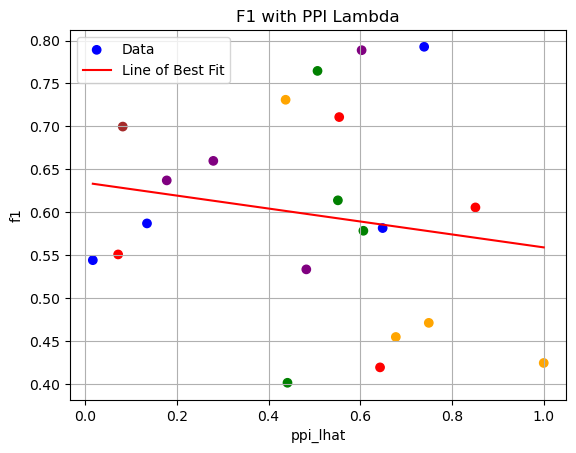

In [309]:
import matplotlib.pyplot as plt
import numpy as np

# Unique site names
unique_sites = ['mexico', 'ap', 'up', 'dar', 'bohol', 'pemba']

# Define colors for each site
site_colors = {
    'mexico': 'blue',
    'ap': 'green',
    'up': 'red',
    'dar': 'orange',
    'bohol': 'purple',
    'pemba': 'brown'
}

# Extracting data from the DataFrame
x_values = results_df['ppi_lhat']
y_values = results_df['f1']
site_names = results_df['site']  # Assuming 'site' column contains site names

# Plotting the scatter plot with points colored by 'site'
colors = [site_colors[site] for site in site_names]
plt.scatter(x_values, y_values, c=colors, label='Data')

# Fitting a line of best fit
coefficients = np.polyfit(x_values, y_values, 1)
polynomial = np.poly1d(coefficients)
x_line = np.linspace(min(x_values), max(x_values), 100)
y_line = polynomial(x_line)

# Plotting the line of best fit
plt.plot(x_line, y_line, color='red', label='Line of Best Fit')

# Adding labels and legend
plt.xlabel('ppi_lhat')
plt.ylabel('f1')
plt.title('F1 with PPI Lambda')
plt.legend()

# Displaying the plot
plt.grid(True)
plt.show()


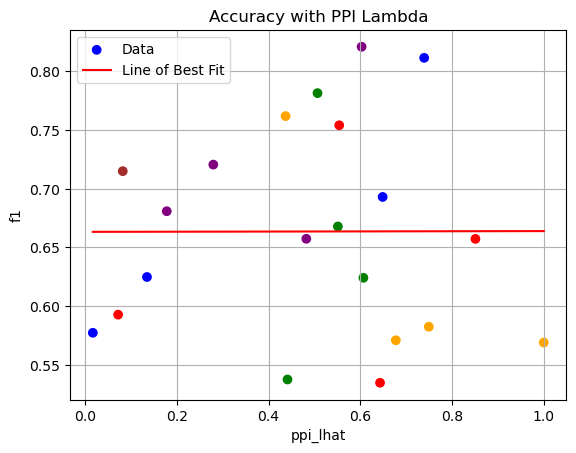

In [310]:
import matplotlib.pyplot as plt
import numpy as np

# Unique site names
unique_sites = ['mexico', 'ap', 'up', 'dar', 'bohol', 'pemba']

# Define colors for each site
site_colors = {
    'mexico': 'blue',
    'ap': 'green',
    'up': 'red',
    'dar': 'orange',
    'bohol': 'purple',
    'pemba': 'brown'
}

# Extracting data from the DataFrame
x_values = results_df['ppi_lhat']
y_values = results_df['accuracy']
site_names = results_df['site']  # Assuming 'site' column contains site names

# Plotting the scatter plot with points colored by 'site'
colors = [site_colors[site] for site in site_names]
plt.scatter(x_values, y_values, c=colors, label='Data')

# Fitting a line of best fit
coefficients = np.polyfit(x_values, y_values, 1)
polynomial = np.poly1d(coefficients)
x_line = np.linspace(min(x_values), max(x_values), 100)
y_line = polynomial(x_line)

# Plotting the line of best fit
plt.plot(x_line, y_line, color='red', label='Line of Best Fit')

# Adding labels and legend
plt.xlabel('ppi_lhat')
plt.ylabel('f1')
plt.title('Accuracy with PPI Lambda')
plt.legend()

# Displaying the plot
plt.grid(True)
plt.show()


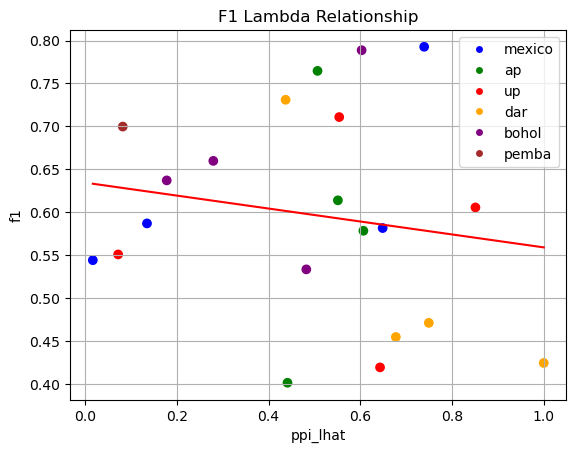

In [320]:
import matplotlib.pyplot as plt
import numpy as np

# Unique site names
unique_sites = ['mexico', 'ap', 'up', 'dar', 'bohol', 'pemba']

# Define colors for each site
site_colors = {
    'mexico': 'blue',
    'ap': 'green',
    'up': 'red',
    'dar': 'orange',
    'bohol': 'purple',
    'pemba': 'brown'
}

# Extracting data from the DataFrame
x_values = results_df['ppi_lhat']
y_values = results_df['f1']
site_names = results_df['site']  # Assuming 'site' column contains site names

# Plotting the scatter plot with points colored by 'site'
colors = [site_colors[site] for site in site_names]
scatter = plt.scatter(x_values, y_values, c=colors, label='Data')

# Fitting a line of best fit
coefficients = np.polyfit(x_values, y_values, 1)
polynomial = np.poly1d(coefficients)
x_line = np.linspace(min(x_values), max(x_values), 100)
y_line = polynomial(x_line)

# Plotting the line of best fit
plt.plot(x_line, y_line, color='red', label='Line of Best Fit')

# Adding labels and legend
plt.xlabel('ppi_lhat')
plt.ylabel('f1')
plt.title('F1 Lambda Relationship')

# Custom legend entries for each site
legend_handles = []
for site in unique_sites:
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=site, markerfacecolor=site_colors[site]))

# Add legend with custom handles
plt.legend(handles=legend_handles)

# Displaying the plot
plt.grid(True)
plt.show()


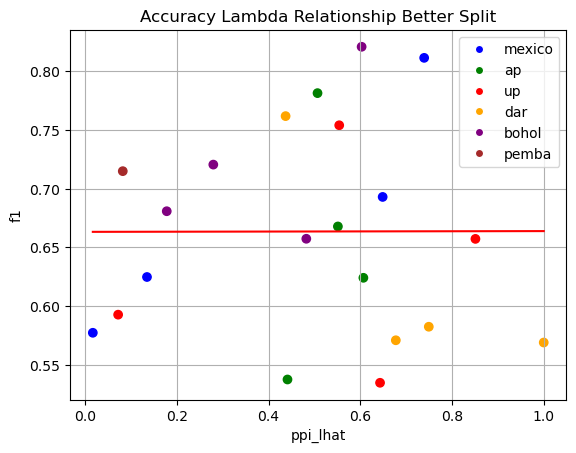

In [312]:
import matplotlib.pyplot as plt
import numpy as np

# Unique site names
unique_sites = ['mexico', 'ap', 'up', 'dar', 'bohol', 'pemba']

# Define colors for each site
site_colors = {
    'mexico': 'blue',
    'ap': 'green',
    'up': 'red',
    'dar': 'orange',
    'bohol': 'purple',
    'pemba': 'brown'
}

# Extracting data from the DataFrame
x_values = results_df['ppi_lhat']
y_values = results_df['accuracy']
site_names = results_df['site']  # Assuming 'site' column contains site names

# Plotting the scatter plot with points colored by 'site'
colors = [site_colors[site] for site in site_names]
scatter = plt.scatter(x_values, y_values, c=colors, label='Data')

# Fitting a line of best fit
coefficients = np.polyfit(x_values, y_values, 1)
polynomial = np.poly1d(coefficients)
x_line = np.linspace(min(x_values), max(x_values), 100)
y_line = polynomial(x_line)

# Plotting the line of best fit
plt.plot(x_line, y_line, color='red', label='Line of Best Fit')

# Adding labels and legend
plt.xlabel('ppi_lhat')
plt.ylabel('f1')
plt.title('Accuracy Lambda Relationship')

# Custom legend entries for each site
legend_handles = []
for site in unique_sites:
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=site, markerfacecolor=site_colors[site]))

# Add legend with custom handles
plt.legend(handles=legend_handles)

# Displaying the plot
plt.grid(True)
plt.show()


In [313]:
# Extracting confidence interval widths
baseline_width = results_df.iloc[row]['baseline_ci'][:, :, 1] - results_df.iloc[row]['baseline_ci'][:, :, 0]
naive_width = results_df.iloc[row]['naive_ci'][:, :, 1] - results_df.iloc[row]['naive_ci'][:, :, 0]
ppi_width = results_df.iloc[row]['ppi_ci'][1] - results_df.iloc[row]['ppi_ci'][0]

In [314]:
np.sum(baseline_width)

0.15643288445981324

In [315]:
baseline_width

array([[0.03894462],
       [0.03871363],
       [0.04056201],
       [0.03821263]])

In [316]:
naive_width

array([[0.05091381],
       [0.04956402],
       [0.05205636],
       [0.04932818]])

In [317]:
ppi_width

array([0.12330768, 0.11440633, 0.13347938, 0.11501913])

In [318]:
row=0

In [319]:
# loop over rows of results_df and compute ratio of the width of CI for naive and ppi
naive_ci_width_ratios = []
ppi_ci_width_ratios = []

for row in tqdm(range(results_df.shape[0])):
        
    # Extracting confidence interval widths
    baseline_width = results_df.iloc[row]['baseline_ci'][:, :, 1] - results_df.iloc[row]['baseline_ci'][:, :, 0]
    naive_width = results_df.iloc[row]['naive_ci'][:, :, 1] - results_df.iloc[row]['naive_ci'][:, :, 0]
    ppi_width = results_df.iloc[row]['ppi_ci'][1] - results_df.iloc[row]['ppi_ci'][0]
    
    # Calculate ratios for each pair of confidence intervals
    naive_ratio = baseline_width / naive_width
    ppi_ratio = baseline_width / ppi_width
    
    naive_ci_width_ratios.append(naive_ratio)
    ppi_ci_width_ratios.append(ppi_ratio)
    
# add to results_df
results_df['naive_ci_width_ratio'] = naive_ci_width_ratios
results_df['ppi_ci_width_ratio'] = ppi_ci_width_ratios

  0%|          | 0/21 [00:00<?, ?it/s]